In [1]:
import time
import numpy as np
import pandas as pd
import cvxpy as cp
import clarabel
import scs
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tqdm_notebook
from notebook_utils.utils import * 
from pycss.utils import *
from pycss.CSS import * 
from pycss.subset_selection import complement 
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri as n2r
from rpy2.robjects.vectors import StrVector

In [2]:
def avg_R2(Sigma, S, include_selected=True):
    p = Sigma.shape[0]
    Sigma_R = regress_off(Sigma, S)
    if not include_selected:
        S_comp = complement(p, S)
    else:
        S_comp = np.arange(p)
    resid_var = np.diag(Sigma_R)[S_comp]
    var = np.diag(Sigma)[S_comp]
    return np.mean((var - resid_var)/var)

In [3]:
standardize = True

T = pd.read_csv("../data/topic_exposure.csv").to_numpy()[:, 1:].astype(float)
D = pd.read_csv("../data/specific_variance.csv").to_numpy()[:, 1:].astype(float)
X = pd.read_csv("../data/factor_exposure.csv").to_numpy()[:, 1:].astype(float)
F = pd.read_csv("../data/factor_covariance.csv").to_numpy()[:, 1:].astype(float)

V = X @ F @ X.T + np.diag(np.squeeze(D))
Sigma = T.T @ V @ T

p = Sigma.shape[0]

cut = p
cut_indices = np.random.choice(np.arange(p), size=cut, replace=False)
Sigma = Sigma[:cut, :cut]

p = Sigma.shape[0]

if standardize:
    Sigma = standardize_cov(Sigma)

eigs, vecs = np.linalg.eig(Sigma)
wh = eigs > 0
eigs = np.real(eigs[wh])
vecs = np.real(vecs[:, wh])
X = np.real(np.sqrt(p) * np.sqrt(eigs)[:, None] * vecs.T)
print(np.allclose(1/p * X.T @ X, Sigma))

True


In [4]:
n2r.activate()
glmnet = rpackages.importr('glmnet')
base = rpackages.importr('base')

In [5]:
p_max = 30
num_inits = 25

### Random

In [6]:
css_random_var_explained = np.zeros((p_max, num_inits))

for i in range(1, p_max + 1):
    for j in range(num_inits):
        S = np.random.choice(np.arange(p), size=i)
        css_random_var_explained[i-1, j] = avg_R2(Sigma, S)


In [9]:
#random_df = pd.DataFrame({'Number of Principal Components/Variables': np.array([ num_inits*[i] for i in range(1, p_max+1) ]).flatten() , 'Average R^2': css_random_var_explained.flatten()  } ) 

In [7]:
random_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1), 'Average $R^2$': np.max(css_random_var_explained, axis=1)  } ) 

### Group Lasso

In [8]:
with localconverter(robjects.default_converter + n2r.converter) as cv:
    fit = glmnet.glmnet(X, X, standardize=False, intercept=False, family="mgaussian", alpha=1, dfmax=30)
    
len_dfs = len(fit['df'])
coeff_path = np.dstack([base.as_matrix(fit['beta'][resp]) for resp in fit['beta'].keys()]).transpose((0, 2, 1))
group_lasso_Ss = []
for i in range(len_dfs):
    group_lasso_Ss.append(np.squeeze(np.argwhere(~np.all(coeff_path[:, :, i] == 0, axis=1))))

dfs = fit['df'][1:]
group_lasso_Ss = group_lasso_Ss[1:]
for i in range(len(group_lasso_Ss)):
    if len(group_lasso_Ss[i].shape) == 0:
        group_lasso_Ss[i] = np.array([group_lasso_Ss[i]])

num_selected = []
css_group_lasso_var_explained = []
for i in range(len(fit['df'])):
    df = fit['df'][i]
    if df > 0 and df <= p_max and df not in num_selected:
        num_selected.append(df)
        css_group_lasso_var_explained.append(avg_R2(Sigma, group_lasso_Ss[i]))
            

In [9]:
group_lasso_df = pd.DataFrame({'Number of Principal Components/Variables': num_selected , 'Average $R^2$': css_group_lasso_var_explained})

### Greedy

In [10]:
css_greedy_var_explained = np.zeros(p_max)
css = CSS()
css.select_subset_from_cov(Sigma, k=p_max, method='greedy')
for i in range(1, p_max + 1):
    css_greedy_var_explained[i - 1] =  avg_R2(Sigma, css.S[:i]) 


In [11]:
greedy_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1), 'Average $R^2$': css_greedy_var_explained })

### Swapping

In [12]:
css = CSS()
css_swap_var_explained = np.zeros(p_max)
for i in tqdm_notebook(range(1, p_max + 1)):
    css.select_subset_from_cov(Sigma, k=i, method='swap', num_inits=num_inits)
    css_swap_var_explained[i-1] = avg_R2(Sigma, css.S)

  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
swap_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1) , 'Average $R^2$': css_swap_var_explained } ) 

### CPFS

If you want to run this, uncomment out the relevant plots and make sure to run it with only 50ish variables (change cut to 50 or around there). 

In [ ]:
def cpfs_cvxpy(X, reg_coeff, tol = 1e-6):
    A = cp.Variable((p, p))
    s = cp.Variable(p)
    lamb = cp.Parameter(nonneg=True)
    objective = cp.Minimize(cp.sum(cp.sum_squares(X  - X @ A)) + lamb * cp.sum(s))
    constraints = [-s[:, None] <= A, A <= s[:, None], s >= 0]
    prob = cp.Problem(objective, constraints)


    lamb.value = reg_coeff
    result = prob.solve(solver='CLARABEL')
    return np.where(s.value > 1e-6)[0]

In [ ]:
num_selected = []
css_cpfs_var_explained = []

lambs = np.flip(np.logspace(0, 3.5, 100))
cpfs_Ss = []
for lamb in tqdm_notebook(lambs):
    S = cpfs_cvxpy(X, lamb)
    df = len(S)
    if df > 0 and df <= p_max and df not in num_selected:
        cpfs_Ss.append(S)
        num_selected.append(df)
        css_cpfs_var_explained.append(avg_R2(Sigma, S))

In [ ]:
cpfs_df = pd.DataFrame({'Number of Principal Components/Variables': num_selected , 'Average $R^2$': css_cpfs_var_explained})

### PCA

In [14]:
pca_df = pd.DataFrame({'Number of Principal Components/Variables': np.arange(1, p_max + 1), 'Average $R^2$': [np.sum(eigs[:i])/np.sum(eigs) for i in range(1, p_max + 1)] })

### Plot

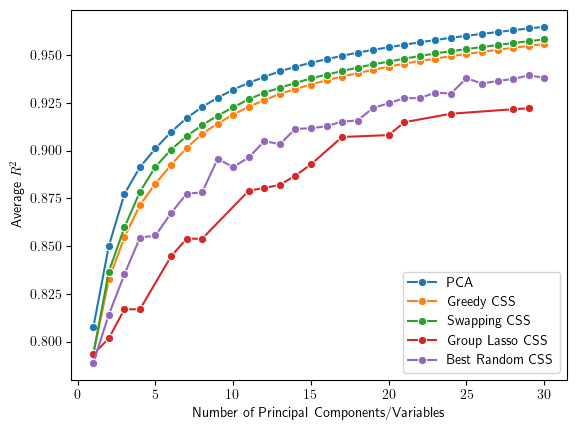

In [18]:
sns.lineplot(data=pca_df,
                 x='Number of Principal Components/Variables', 
                 y='Average $R^2$', 
                 marker='o',
                 errorbar=('se', 1),
                 label='PCA')

sns.lineplot(data=greedy_df,
                 x='Number of Principal Components/Variables', 
                 y='Average $R^2$', 
                 marker='o',
                 errorbar=('se', 1),
                 label='Greedy CSS')

sns.lineplot(data=swap_df,
                 x='Number of Principal Components/Variables', 
                 y='Average $R^2$', 
                 marker='o',
                 errorbar=('pi', 100),
                 label='Swapping CSS')

sns.lineplot(data=group_lasso_df,
                 x='Number of Principal Components/Variables', 
                 y='Average $R^2$', 
                 marker='o',
                 errorbar=('se', 1),
                 label='Group Lasso CSS')

sns.lineplot(data=random_df,
                 x='Number of Principal Components/Variables', 
                 y='Average $R^2$', 
                 marker='o',
                 errorbar=('pi', 100),
                 label='Best Random CSS')

#sns.lineplot(data=cpfs_df,
#                 x='Number of Principal Components/Variables', 
#                 y='Average R^2', 
#                 marker='o',
#                 errorbar=('pi', 100),
#                 label='cpfs')
plt.rc('text', usetex=True)
#plt.savefig("../figures/blackrock_results.pdf")

Check correlations in selected subsets

In [45]:
#cpfs_max_eig = []
#cpfs_eig_var = []
#cpfs_dfs = []
#cpfs_det = []
#cpfs_det_sign = []
#for S in cpfs_Ss:
#    cpfs_dfs.append(len(S))
#    Sig = Sigma[S, :][: , S]
#    eig = np.linalg.eig(Sig)[0]
#    cpfs_max_eig.append(np.max(eig))
#    cpfs_eig_var.append(np.std(eig))
#    cpfs_det.append(np.linalg.slogdet(Sig)[1])
#    cpfs_det_sign.append(np.linalg.slogdet(Sig)[0])
    
random_max_eig = []
random_eig_var = []
random_det = []
random_det_sign = []
for i in range(1, p_max + 1):
    S = np.random.choice(np.arange(p), replace=False, size=i)
    Sig = Sigma[S, :][: , S]
    eig = np.linalg.eig(Sig)[0]
    random_max_eig.append(np.max(eig))
    random_eig_var.append(np.std(eig))
    random_det.append(np.linalg.slogdet(Sig)[1])
    random_det_sign.append(np.linalg.slogdet(Sig)[0])

lasso_max_eig = []
lasso_eig_var = []
lasso_dfs = []
lasso_det = []
lasso_det_sign = []
for S in group_lasso_Ss:
    lasso_dfs.append(len(S))
    Sig = Sigma[S, :][: , S]
    eig = np.linalg.eig(Sig)[0]
    lasso_max_eig.append(np.max(eig))
    lasso_eig_var.append(np.std(eig))
    lasso_det.append(np.linalg.slogdet(Sig)[1])
    lasso_det_sign.append(np.linalg.slogdet(Sig)[0])
    
greedy_max_eig = []
greedy_eig_var = []
greedy_det = []
greedy_det_sign = []
for i in range(1, p_max + 1):
    Sig = Sigma[css.S[:i], :][: , css.S[:i]]
    eig = np.linalg.eig(Sig)[0]
    greedy_max_eig.append(np.max(eig))
    greedy_eig_var.append(np.std(eig))
    greedy_det.append(np.linalg.slogdet(Sig)[1])
    greedy_det_sign.append(np.linalg.slogdet(Sig)[0])

plot maximum eigenvalue of covariance of selected subsets


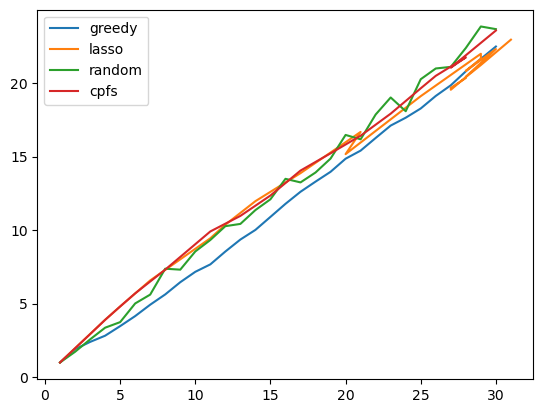

In [47]:
print('plot maximum eigenvalue of covariance of selected subsets')
plt.plot(np.arange(1, p_max + 1), greedy_max_eig, label='greedy')
plt.plot(lasso_dfs, lasso_max_eig, label='lasso')
plt.plot(np.arange(1, p_max + 1), random_max_eig, label='random')
plt.plot(cpfs_dfs, cpfs_max_eig, label='cpfs')
plt.legend()

plot variation in the eigenvalues of covariance of selected subsets


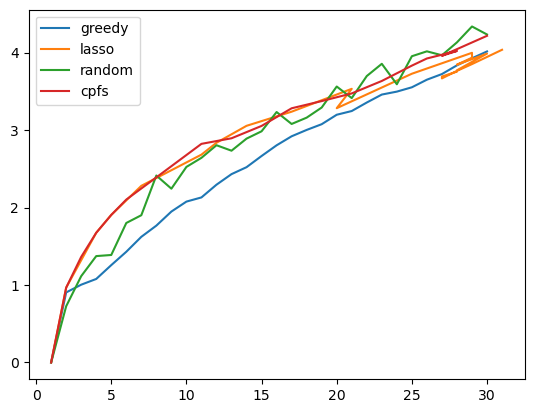

In [48]:
print('plot variation in the eigenvalues of covariance of selected subsets')
plt.plot(np.arange(1, p_max + 1), greedy_eig_var, label='greedy')
plt.plot(lasso_dfs, lasso_eig_var, label='lasso')
plt.plot(np.arange(1, p_max + 1), random_eig_var, label='random')
plt.plot(cpfs_dfs, cpfs_eig_var, label='cpfs')
plt.legend()

plot log determinant of covariance of selected subsets


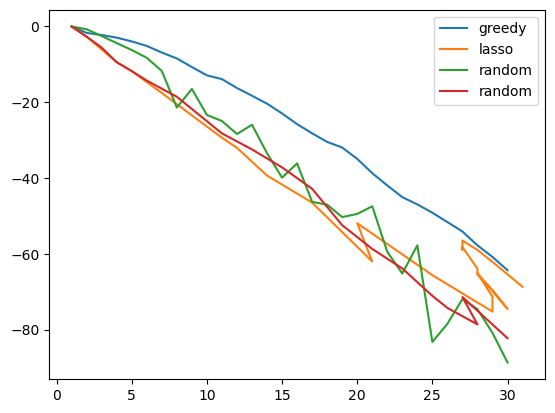

In [49]:
print('plot log determinant of covariance of selected subsets')
plt.plot(np.arange(1, p_max + 1), greedy_det, label='greedy')
plt.plot(lasso_dfs, lasso_det, label='lasso')
plt.plot(np.arange(1, p_max + 1), random_det, label='random')
plt.plot(cpfs_dfs, cpfs_det, label='random')
plt.legend()

Compare greedy runtime to naive

In [37]:
p_max = 30

css = CSS()
start = time.time()
css.select_subset_from_cov(Sigma, k=p_max, method='greedy')
end = time.time()
efficient_time = end - start

start = time.time()
S = np.array([]).astype(int)
for i in tqdm_notebook(range(p_max)):
    options = complement(p, S)
    best_val = np.inf
    best_j = np.nan
    for j in options:
        option_val = np.mean(np.diag(regress_off(Sigma, np.concatenate([S, np.array([j])]))))
        if option_val < best_val:
            best_val = option_val
            best_j = j
    S = np.concatenate([S, np.array([j])])
end = time.time()
naive_time = end - start

print(efficient_time)
print(naive_time)
print(naive_time/efficient_time)

  0%|          | 0/30 [00:00<?, ?it/s]

0.08734822273254395
366.3366539478302
4193.979482210364


Compare swapping runtime to naive

In [27]:
p_max = 30

start = time.time()
css = CSS()
css.select_subset_from_cov(Sigma, k=p_max, method='swap')
end = time.time()
# time to select entire subset
whole_time = end - start 

start = time.time()
css.select_subset_from_cov(Sigma, k=p_max, method='swap', S_init=css.S)
end = time.time()
# time to efficiently verify a local optimum is a local optimum
efficient_time = end - start

start = time.time()
S = css.S.copy()
for i in range(len(S)):
    current_val = np.mean(np.diag(regress_off(Sigma, S)))
    options = np.delete(np.arange(p), S)
    best = np.inf 
    best_S_option = np.nan
    for j in options:
        S_option = S.copy()
        S_option[i] = j
        option_val = np.mean(np.diag(regress_off(Sigma, S_option)))
        if option_val < best:
            best = option_val
            best_S_option = S_option
    if best < current_val:
        S = best_S_option.copy()
    break
end = time.time()
# time to naively verify a local optimum is a local optimum
naive_time = (end - start) * p_max

In [28]:
print(whole_time)
print(naive_time/efficient_time)

0.6134529113769531
5167.990937605291


In [29]:
# modified swapping selection so that it returns the number of iterations it takes  
def modified_css_with_init(Sigma,
                           S_init,
                           max_iter,
                           include,
                           exclude,
                           tol=TOL):
    
    '''
    Performs swapping CSS with a particular initialization. See `swapping_CSS` for a description 
    of inputs. 
    '''
    
    k = len(S_init)
    p = Sigma.shape[0]
    d = p-k
    include_set = set(include)

    idx_order = np.arange(p)

    Sigma_R = Sigma.copy()
    # these will always be the indices of the selected subset
    subset_idxs = np.arange(d, p)
    # swap initial variables to bottom of Sigma
    swap_in_place(Sigma_R, subset_idxs, S_init, idx_order=idx_order) #order of idxs1 and idxs2 is important!
    S = idx_order[d:].copy()
    Sigma_S = Sigma[:, S][S, :]
    invertible, Sigma_S_L = is_invertible(Sigma_S)   

    if not invertible:
        return None

    #regress out original subset
    regress_off_in_place(Sigma_R, np.arange(d, p), tol=tol)

    # number of completed iterations
    N = 0
    # counter of how many consecutive times we have chose not to swap 
    not_replaced = 0
    # permutation which shifts the last variable in the subset to the top of the subset
    subset_idxs_permuted = np.concatenate([subset_idxs[1:], np.array([subset_idxs[0]])])
    converged = False

    while N < max_iter and (not converged):
        for i in range(k):
            S_0 = S[0]

            # Update cholesky after removing first variable from subset
            Sigma_T_L = update_cholesky_after_removing_first(Sigma_S_L)

            if S_0 not in include_set:
            
                # Subset with first variable removed  from selected subset
                T = S[1:].copy()

                # Update residual covariance after removing first variable from subset
                v = Sigma[:, S_0] - Sigma[:, T] @ solve_with_cholesky(Sigma_T_L, Sigma[T, S_0]) if k > 1 else Sigma[:, S_0]
                reordered_v = v[idx_order]
                Sigma_R = Sigma_R + np.outer(reordered_v, reordered_v)/v[S_0]
                
                # Swap first variable from subset to to top of residual matrix
                swap_in_place(Sigma_R, np.array([0]), np.array([d]), idx_order=idx_order)

                # find indices of variables with zero variance
                zero_idxs = np.where(np.diag(Sigma_R)[:(d + 1)] <= tol)[0]
                num_zero_idxs = len(zero_idxs)
                # In residual matrix, swap variables with zero indices to right above currently selected subset (of size k-1)
                swap_in_place(Sigma_R, np.arange(d + 1 - num_zero_idxs, d + 1), zero_idxs, idx_order=idx_order) #order of idxs1 and idxs2 is important!

                # update num_active
                num_active = d + 1 - num_zero_idxs

                # compute objectives and for active variables and find minimizers
                obj_vals = css_score(Sigma_R[:num_active, :num_active], tol=tol)

                # set the objective value to infinity for the excluded variables
                obj_vals[np.in1d(idx_order[:num_active], exclude)] = np.inf

                choices = np.flatnonzero(obj_vals == obj_vals.min())

                # if removed variable is a choice, select it, otherwise select a random choice
                if 0 in choices:
                    not_replaced += 1
                    j_star = 0
                else:
                    not_replaced = 0
                    j_star = np.random.choice(choices)
                
                S_new = idx_order[j_star]
                
                # In residual covariance, regress selected variable off the remaining
                #regress_one_off_in_place(Sigma_R[:(d+1), :(d+1)], j_star) #alternative option
                regress_one_off_in_place(Sigma_R[:num_active, :num_active], j_star)
                # In residual covariance swap new choice to top of selected subset 
                swap_in_place(Sigma_R, np.array([d]), np.array([j_star]), idx_order=idx_order)
              
            else:
                S_new = S_0 
            
            # Add new choice as the last variable in selected subset
            S[:k-1] = S[1:]
            S[k-1] = S_new

            # Update cholesky after adding new choice as last variable in selected subset
            Sigma_S_L = update_cholesky_after_adding_last(Sigma_T_L, Sigma[S_new, S])

            # permute first variables in selected subset to the last variable in the residual matrix
            perm_in_place(Sigma_R, subset_idxs,  subset_idxs_permuted, idx_order=idx_order)
                
            if not_replaced == k - len(include):
                converged=True
                break
       
        N += 1

    perm_in_place(Sigma_R, np.arange(p), np.argsort(idx_order))
    
    return N

In [33]:
B = 100
iters = []
for i in tqdm_notebook(range(B)):
    N = modified_css_with_init(Sigma=Sigma,
                               S_init=np.random.choice(np.arange(p), p_max, replace=False),
                               max_iter=100,
                               include=np.array([]),
                               exclude=np.array([]),
                               tol=TOL)
    if N is not None:
        iters.append(N)


  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 1.,  0., 44.,  0., 38.,  0., 12.,  0.,  3.,  1.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <BarContainer object of 10 artists>)

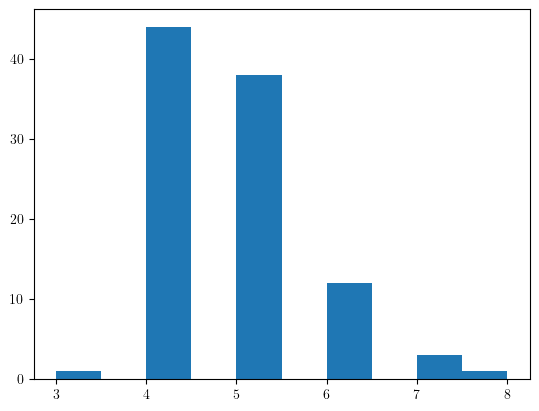

In [34]:
plt.hist(iters)

In [35]:
print(naive_time * np.median(iters))
print(naive_time * np.mean(iters))

3547.2593665122986
3368.1048530520816
